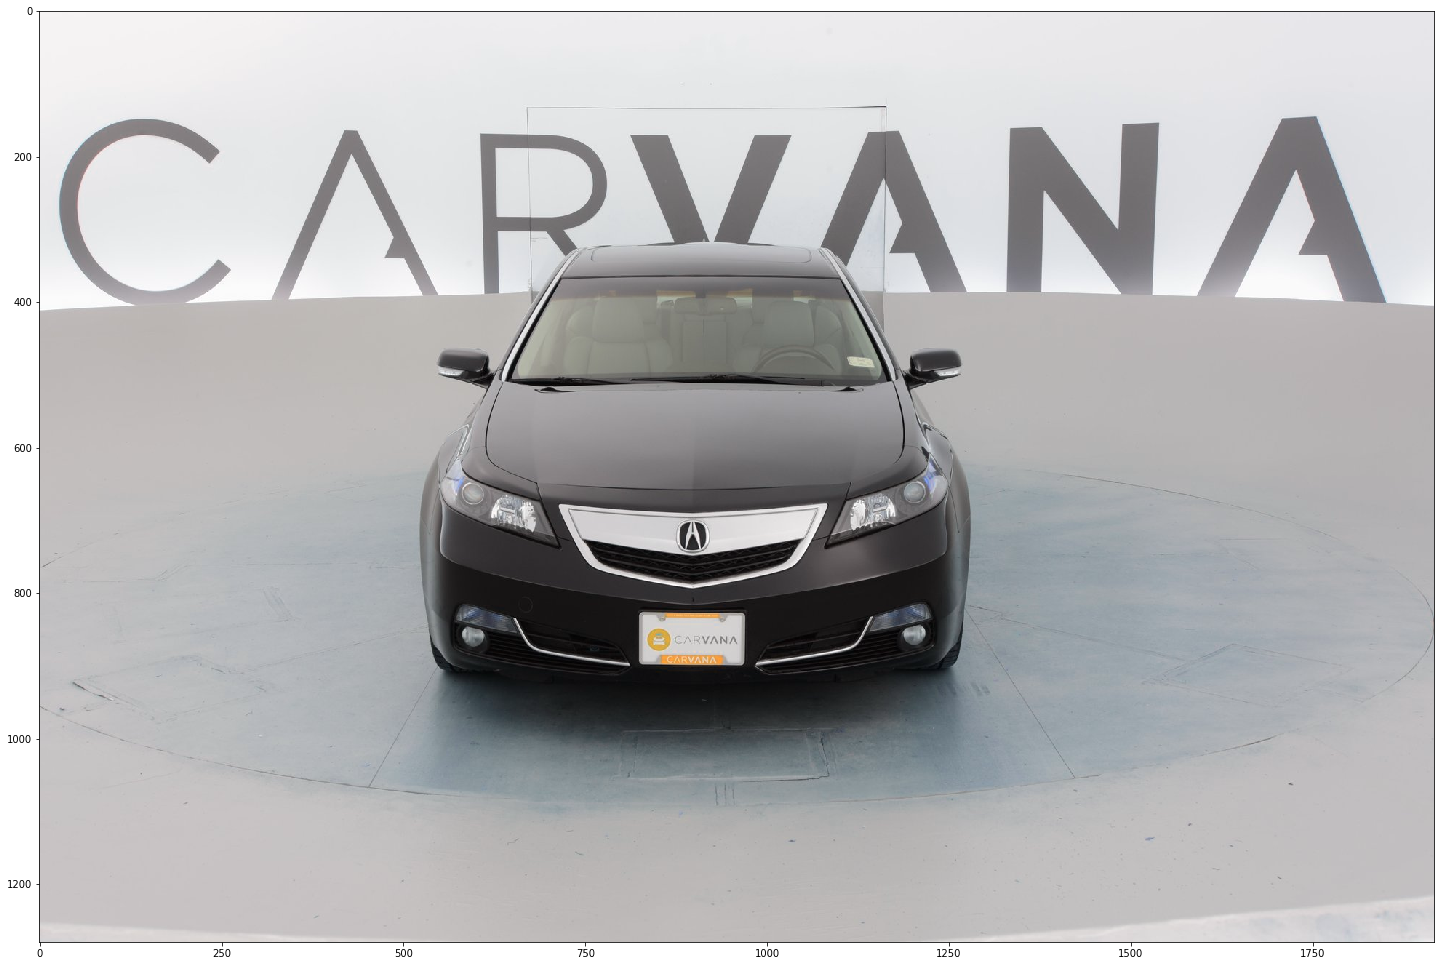

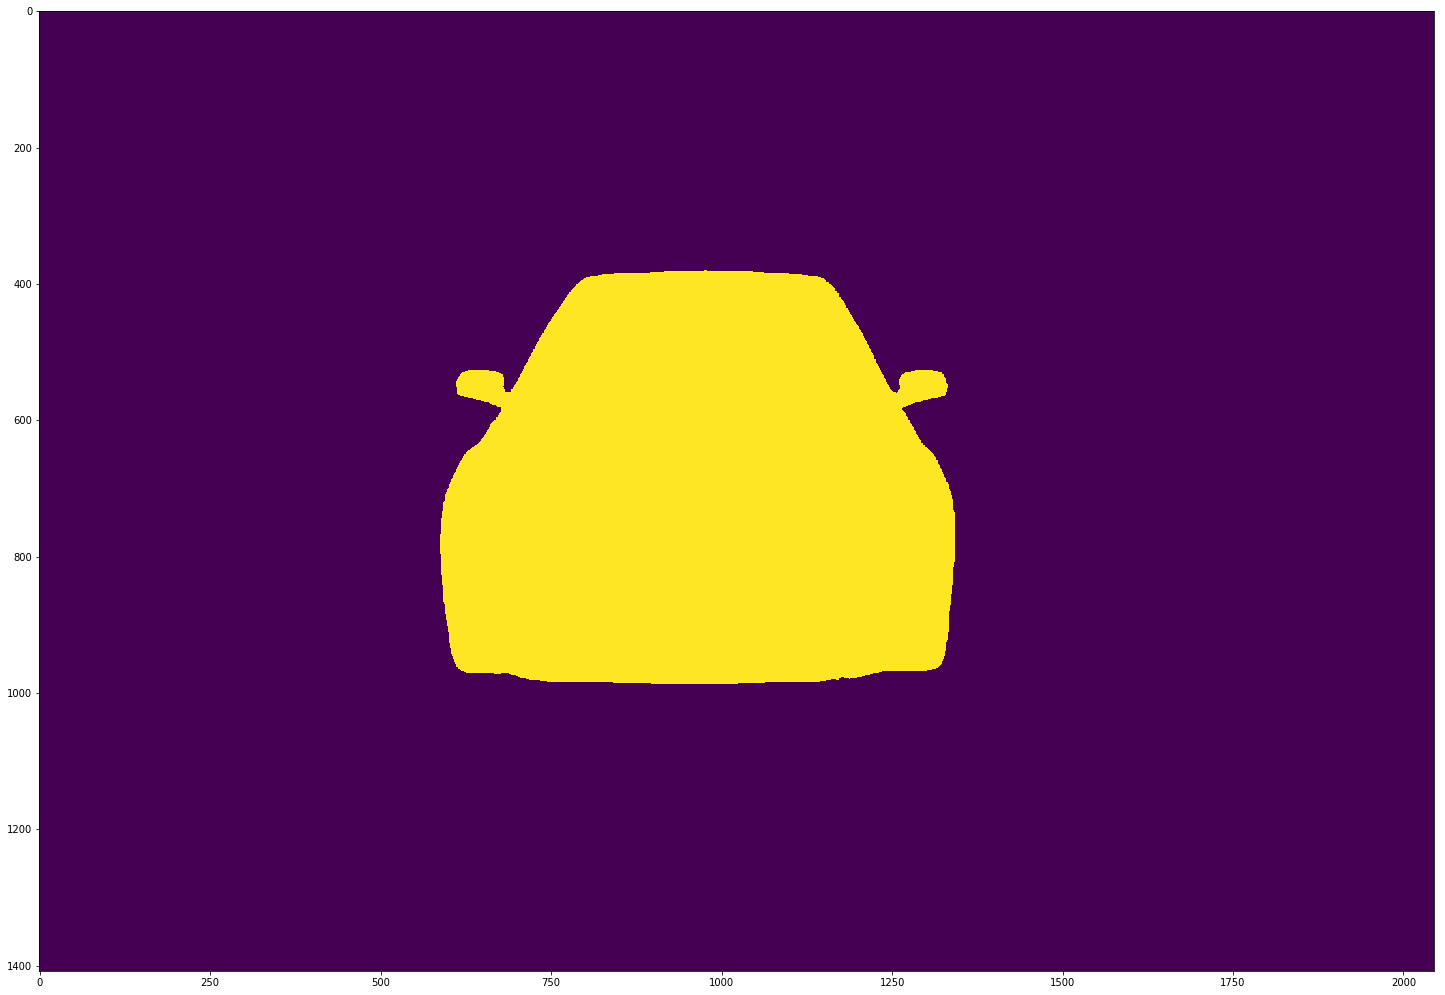

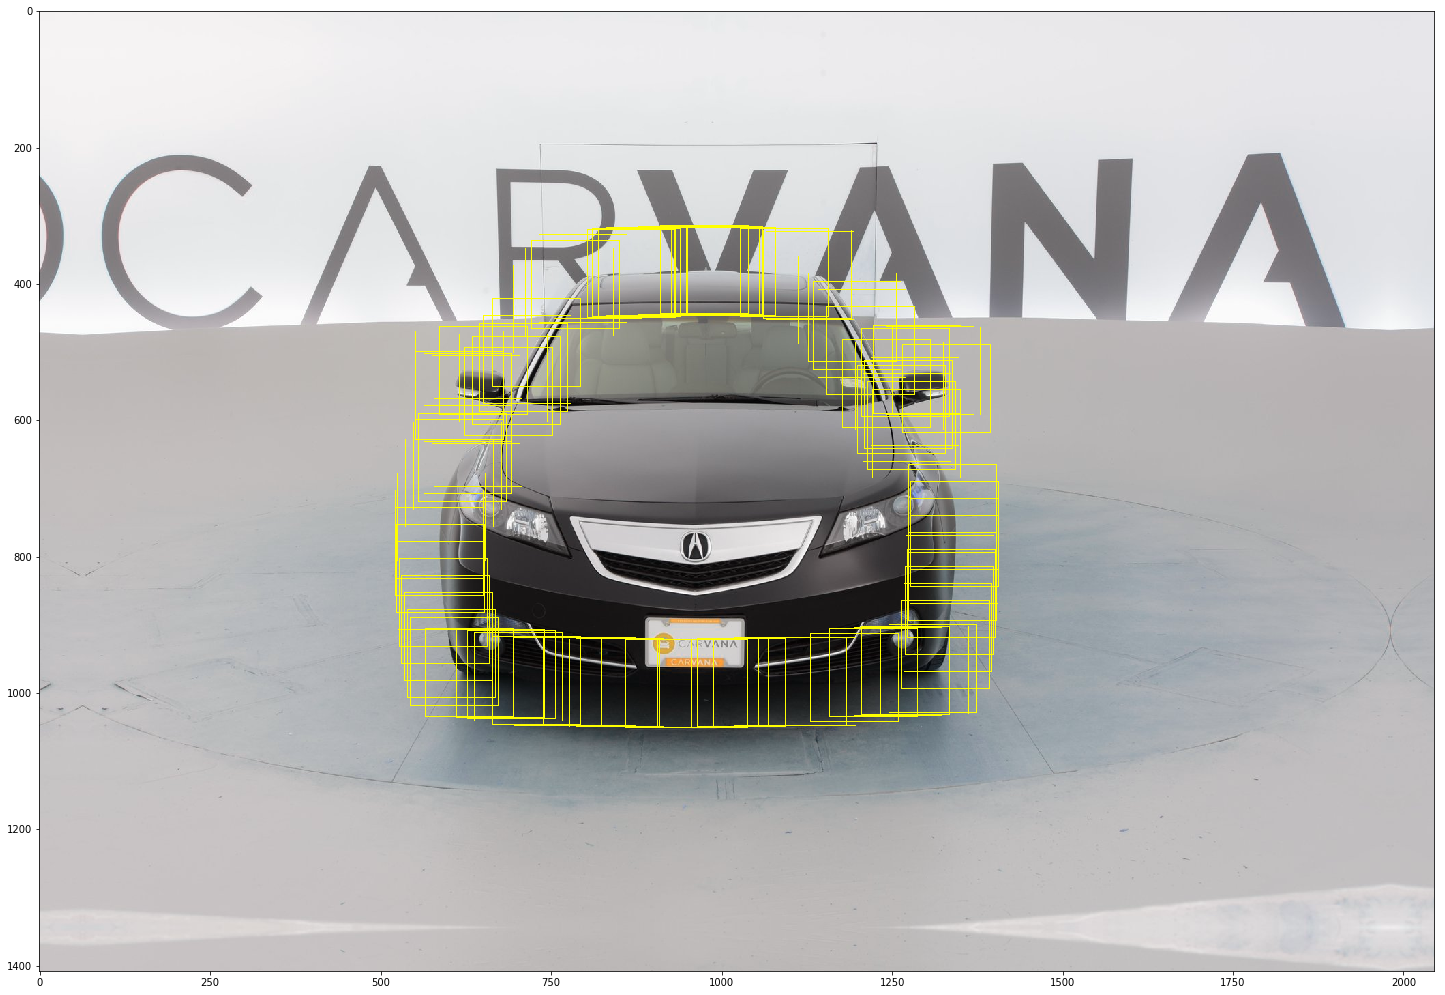

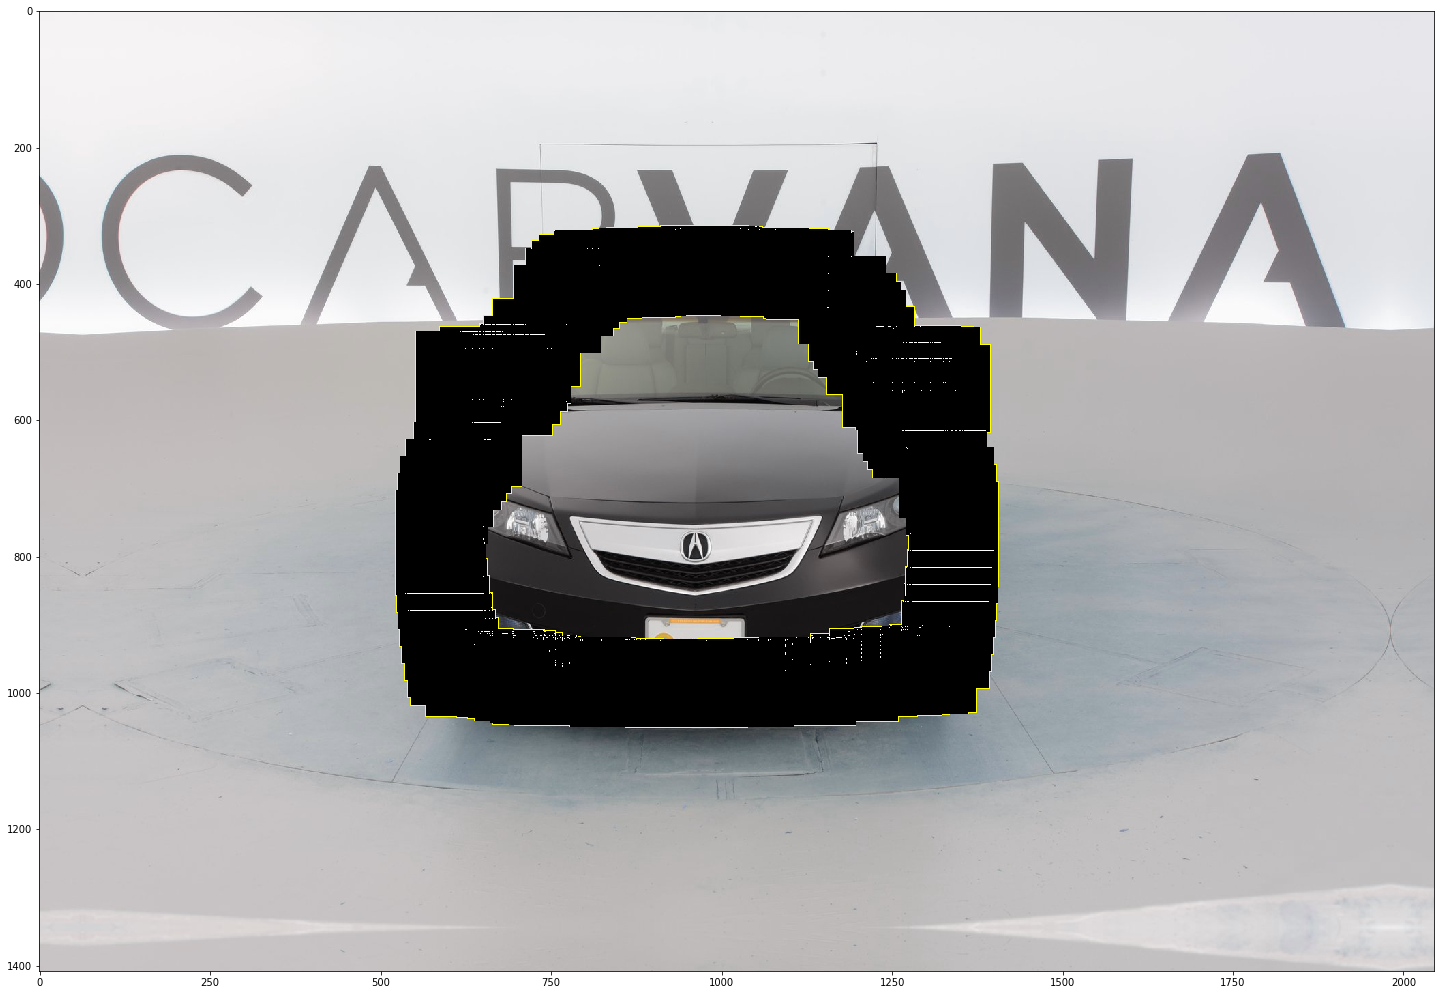

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import scipy.misc as misc
import os
from u_net import get_unet_128, get_unet_256

# patch size
N = 128
input_size = 128
batch_size = 32
threshold = 0.5
model = get_unet_128((input_size, input_size, 3))
#model.load_weights(filepath='weights/patchesnet_unet128_noaug_sym_pad')


def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

def run_length_encode(mask):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    inds = mask.flatten()
    runs = np.where(inds[1:] != inds[:-1])[0] + 2
    runs[1::2] = runs[1::2] - runs[:-1:2]
    rle = ' '.join([str(r) for r in runs])
    return rle


with open("/data/pavel/fcn/DeepLab/unet2/submit/best_weights_skipcon_new_masks.csv") as csv:
    for x in csv:
        x = x.strip()

        if 'rle' in x:
            continue

        original_image = cv2.imread('/data/pavel/carv/test_hq/%s' % x.split(',')[0])
        img = original_image
        img = np.pad(img, ((N // 2, N // 2), (N // 2, N // 2), (0, 0)), 'symmetric')
        
        plt.figure(figsize=(25, 25))
        plt.imshow(original_image)
        plt.show()
        
        mask = rle_decode(x.split(',')[1], (1280, 1918))
        original_mask = mask
        mask = np.pad(mask, ((N // 2, N // 2), (N // 2, N // 2)), 'symmetric')
        
        plt.figure(figsize=(25, 25))
        plt.imshow(mask)
        plt.show()
        
        border = np.abs(np.gradient(mask)[1]) + np.abs(np.gradient(mask)[0])
        border = np.select([border == 0.5, border != 0.5], [1.0, border])
        
        height, width = mask.shape
        
        height, width = mask.shape

        patches_img = []
        patches_loc = []

        i = 0
        for x, y in zip(np.nonzero(border)[0], np.nonzero(border)[1]):
            if i % 50 == 0 and x - N // 2 >= 0 and y - N // 2 >= 0:
                cv2.rectangle(img,(y-N//2-1,x-N//2-1),(y+N//2,x+N//2),(255,255,0),1)
                patches_img.append(img[x - N // 2:x + N // 2, y - N // 2:y + N // 2, :])
                patches_loc.append([x - N // 2, x + N // 2, y - N // 2, y + N // 2])
            i = i + 1
        
        plt.figure(figsize=(25, 25))
        plt.imshow(img)
        plt.show()
        
        def test_generator():
            while True:
                for start in range(0, len(patches_img), batch_size):
                    x_batch = []
                    end = min(start + batch_size, len(patches_img))
                    test_batch = patches_img[start:end]
                    for img in test_batch:
                        x_batch.append(img)
                    x_batch = np.array(x_batch, np.float32) / 255
                    yield x_batch
                    
        preds = model.predict_generator(generator=test_generator(),
                                    steps=np.ceil(float(len(patches_img)) / float(batch_size)))
        preds = np.squeeze(preds, axis=3)
        
        for pred, patch, loc in zip(preds, patches_img, patches_loc):
            pred = pred > threshold
            
            pred = np.select([pred == True, pred == False], [np.array(255, dtype=np.uint8), np.array(0, dtype=np.uint8)])
            img[loc[0]:loc[1], loc[2]:loc[3],:] = np.dstack([pred,pred,pred])
            
        plt.figure(figsize=(25, 25))
        plt.imshow(img)
        plt.show()
        
        break
